# <div align="center">Data Science with Stock Data - Linear Regression</div>
### <div align="center">Author: <a href="https://www.linkedin.com/in/kaming-yip-22b03a1a0/">Kaming Yip</a>&emsp;&emsp;Date: Mar. 18, 2020</div>

Before start reading this file, you are suggested to read the project instruction in the <a href="https://github.com/KamingYip/Data-Science-with-Stock-Data/blob/master/README.md">README.md</a> file.

One of the difficult questions in Linear Regression is the size of the window <i>W</i>. In this file, we will build a Linear Regression model for stock prices and decide whether we want to hold a (long or short) position overnight. Specifically, we take a window of <i>W</i> days and given the adjusted prices <i>P<sub>1</sub></i> , <i>P<sub>2</sub></i> , ... , <i>P<sub>W</sub></i> for days <i>t</i> = 1, 2, ... , <i>W</i> we estimate the closing price <i>P<sup>*</sup><sub>W + 1</sub></i> for day <i>W</i> + 1 using ordinary Linear Regression. We will choose <i>W</i> based on the profitability of our strategy.
    
We need to decide our investment at the end of day <i>W</i> and decide how to invest for day <i>W</i> + 1. Our trading strategy at the end of day <i>W</i> is the following:

 1. if <i>P<sup>*</sup><sub>W + 1</sub></i> > <i>P<sub>W</sub></i> then we decide that tomorrow the price will rise (daily return for day <i>W</i> + 1 will be positive). In this case we do the following:
    * if we do not have a position, we buy $100 of stock at the closing price <i>P<sub>W</sub></i> . We establish a long position with 100/<i>P<sub>W</sub></i> (fractional) number of shares.
    * if we already have a long position (i.e. we bought yesterday or day(s) before), we keep the position. Since we expect the price to rise the next day, we expect to increase our profit.
    * if we have a short position from yesterday, we close this position by buying the appropriate number of shares. If we established such a short position with <i>x</i> (possibly fractional) number of shares with price <i>P<sub>x</sub></i> , the profit/loss per share will be <i>P<sub>x</sub></i> - <i>P<sub>W</sub></i> .


 2. if <i>P<sup>*</sup><sub>W + 1</sub></i> < <i>P<sub>W</sub></i> then we decide that tomorrow the price will fall (daily return for day <i>W</i> + 1 will be negative). In this case we do the following:
    * if we do not have a position, we sell short $100 of stock at the closing price <i>P<sub>W</sub></i> . We establish a short position with 100/<i>P<sub>W</sub></i> (fractional) number of shares.
    * if we already have a short position (i.e. we sold short yesterday or day(s) before), we keep the position. Since we expect the price to fall the next day, we expect to increase our profit.
    * if we have a long position, we close the position. If we established such a long position with <i>x</i> (possibly fractional) number of shares with price <i>P<sub>x</sub></i> , then the profit/loss per share will be <i>P<sub>W</sub></i> - <i>P<sub>x</sub></i> .


 3. if <i>P<sup>*</sup><sub>W + 1</sub></i> = <i>P<sub>W</sub></i> , then we do nothing (this is a highly unlikely event) and we ignore trading costs.

To start with, we scrape the historical data from <a href="https://finance.yahoo.com/quote/YELP?p=YELP&.tsrc=fin-srch-v1">yahoo web</a> and manipulate the data to create desirable columns.

In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np

In [2]:
def get_stock(ticker, start_date, end_date):
    try:
        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Return'] = 100.0 * df['Return']
        df['Return'] = df['Return'].round(3)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.weekday_name  
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 'Week_Number', 'Year_Week',
                    'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Return']
        df = df[col_list]
        return df
    except Exception as error:
        print(error)
        return None

ticker='YELP'
df = get_stock(ticker, start_date='2018-01-01', end_date='2019-12-31')
df.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return
Date,,,,,,,,,,,,,,
2018-01-02,2018-01-02,2018,1,2,Tuesday,00,2018-00,42.06,43.47,42.06,43.24,1355300,43.24,0.000
2018-01-03,2018-01-03,2018,1,3,Wednesday,00,2018-00,43.35,43.59,42.86,43.12,1347700,43.12,-0.278
2018-01-04,2018-01-04,2018,1,4,Thursday,00,2018-00,43.36,43.53,42.52,42.82,933000,42.82,-0.696
2018-01-05,2018-01-05,2018,1,5,Friday,00,2018-00,42.95,43.34,42.74,43.17,916700,43.17,0.817
2018-01-08,2018-01-08,2018,1,8,Monday,01,2018-01,43.03,43.89,42.72,43.67,807600,43.67,1.158


By far, we have completed the data preparation. From the raw data, we have conducted feature engineering to create new features that we would use in the modeling. We will take daily data for year 2018 and for each window size <i>W</i> = 5, 6, ... ,30 compute the average P/L per trade, in order to find the optimal value <i>W<sup>*</sup></i> of <i>W</i>.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tabulate import tabulate

In [4]:
def linear_regression(data, W):
    """
    to fit the W days adj_close prices with a linear regression model
    and to predict the closing price for day W+1
    """
    money = 100.0
    shares = 0.0
    position = "No"
    long_count = 0
    short_count = 0
    long_price = 0.0
    short_price = 0.0
    long_profit = 0.0
    short_profit = 0.0
    pos_list = []
    r2_list = []
        
    for i in range(len(data) - W):
        x = pd.Series(range(i, i + W))
        x_2 = x[:, np.newaxis]
        y = data.iloc[i : (i + W)]["Adj Close"].values
        lin_reg = LinearRegression(fit_intercept = True)
        lin_reg.fit(x_2, y)
        prev_price = data.iloc[i + W - 1]["Adj Close"]
        new_x = pd.Series(i + W)
        new_x_2 = new_x[:, np.newaxis]
        pred_price = lin_reg.predict(new_x_2)
            
        pred = np.append(data.iloc[i : (i + W - 1)]["Adj Close"].values, pred_price)
        r2_list.append(r2_score(y, pred))
            
        # if P*w+1 > Pw,
        if pred_price > prev_price:
            if position == "No":
                shares = money / prev_price
                long_price = prev_price
                position = "Long"
                pos_list.append(position)
            elif position == "Long":
                pos_list.append(position)
            else:
                PL = (short_price - prev_price) * shares
                shares = 0.0
                position = "No"
                pos_list.append(position)
                short_count += 1
                short_profit += PL
            
        # if P*w+1 < Pw,
        elif pred_price < prev_price:
            if position == "No":
                shares = money / prev_price
                short_price = prev_price
                position = "Short"
                pos_list.append(position)
            elif position == "Short":
                pos_list.append(position)
            else:
                PL = (prev_price - long_price) * shares
                shares = 0.0
                position = "No"
                pos_list.append(position)
                long_count += 1
                long_profit += PL
            
        # if P*w+1 = Pw,
        else:
            pos_list.append(position)
        
    results = pd.Series({"Window Size": W,
                         "Avg P/L per Trade($)": (long_profit + short_profit)/\
                                                 (long_count + short_count),
                         "R2": r2_list,
                         "Long Trans Count": long_count,
                         "Short Trans Count": short_count,
                         "Avg P/L Long($)": long_profit / long_count,
                         "Avg P/L Short($)": short_profit / short_count,
                         "Avg Long Days": pos_list.count("Long") / long_count,
                         "Avg Short Days": pos_list.count("Short") / short_count})       
    
    return results

In [5]:
W_list = list(range(5, 31))
train_df = df[df["Year"] == 2018].copy().reset_index(drop = True)
train_results = pd.DataFrame(columns = ["Window Size", "Avg P/L per Trade($)", "R2", "Long Trans Count",
                                        "Short Trans Count", "Avg P/L Long($)", "Avg P/L Short($)",
                                        "Avg Long Days", "Avg Short Days"])
for i in range(len(W_list)):
    W = W_list[i]
    train_results.loc[i] = linear_regression(train_df, W)
num_cols = train_results.columns.drop("R2")
train_results[num_cols] = train_results[num_cols].apply(pd.to_numeric)
print(tabulate(train_results[num_cols].head().T, numalign = "right"))

--------------------  --------  ---------  ----------  ---------  ---------
Window Size                  5          6           7          8          9
Avg P/L per Trade($)  0.299154   0.144236   -0.192994  -0.183733  -0.827542
Long Trans Count            30         31          29         31         24
Short Trans Count           30         28          29         26         30
Avg P/L Long($)       0.184522   0.369668   -0.332183  0.0333332    -1.8837
Avg P/L Short($)      0.413786  -0.105348  -0.0538057  -0.442544  0.0173843
Avg Long Days          3.13333    3.09677     3.10345          3    3.70833
Avg Short Days         3.06667    3.21429     3.31034    3.57692        3.3
--------------------  --------  ---------  ----------  ---------  ---------


Then we will visualize the average P/L per trade against each window size <i>W</i> and identify the optimal <i>W<sup>*</sup></i> in this metric.

In [6]:
import matplotlib.pyplot as plt

In [7]:
def boundaries_text(data, W_col, col_name):
    label_text_max = "W = {0}\nmax ${1}".format(data.loc[data[col_name].idxmax(), W_col],
                                                round(data[col_name].max(), 2))
    label_x_max = data.loc[data[col_name].idxmax(), W_col]
    label_y_max = round(data[col_name].max(), 2)
        
    label_text_min = "W = {0}\nmin ${1}".format(data.loc[data[col_name].idxmin(), W_col],
                                                round(data[col_name].min(), 2))
    label_x_min = data.loc[data[col_name].idxmin(), W_col]
    label_y_min = round(data[col_name].min(), 2)
        
    return label_text_max, label_x_max, label_y_max,\
           label_text_min, label_x_min, label_y_min

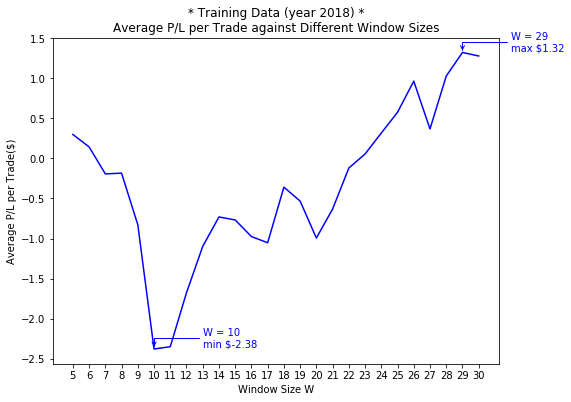

In [8]:
label_text_max_2018, label_x_max_2018, label_y_max_2018,\
    label_text_min_2018, label_x_min_2018, label_y_min_2018 =\
        boundaries_text(train_results, "Window Size", "Avg P/L per Trade($)")
        
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(W_list, "Avg P/L per Trade($)", data = train_results, color = "blue")
ax.annotate(label_text_max_2018, xy = (label_x_max_2018, label_y_max_2018), xycoords = "data",
            xytext = (label_x_max_2018+3, label_y_max_2018), color = "blue",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "blue"),
            ha = "left", va = "bottom")
ax.annotate(label_text_min_2018, xy = (label_x_min_2018, label_y_min_2018), xycoords = "data",
            xytext = (label_x_min_2018+3, label_y_min_2018), color = "blue",
            arrowprops = dict(arrowstyle = "->", connectionstyle = "angle,angleA=0,angleB=90", color = "blue"),
            ha = "left", va = "bottom")

plt.title("* Training Data (year 2018) *\n" + "Average P/L per Trade against Different Window Sizes")
plt.xlabel("Window Size W")
plt.xticks(W_list)
plt.ylabel("Average P/L per Trade($)")
plt.show()

As demonstrated in the curve plot, the average P/L per trade sharply drops down as window size <i>W</i> increases at first and hits its low point at losing $2.38 per trade on average when W = 10. However, the trading strategy starts to bounce back and generally becomes more and more profitable after that and the peak value occurs when W = 29 with the P/L per trade as $1.32 on average.

Therefore, we will take the optimal <i>W<sup>*</sup></i> = 29 and use this value to compute linear regression in testing data, which is the stock price in year 2019.

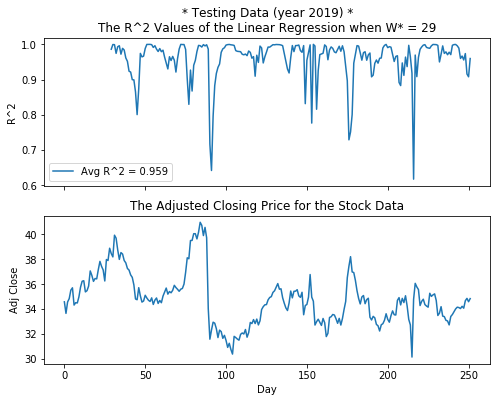

In [9]:
optimal_W = train_results.loc[train_results["Avg P/L per Trade($)"].idxmax(), "Window Size"]
test_df = df[df["Year"] == 2019].copy().reset_index(drop = True)
test_results = pd.DataFrame(columns = ["Window Size", "Avg P/L per Trade($)", "R2", "Long Trans Count",
                                       "Short Trans Count", "Avg P/L Long($)", "Avg P/L Short($)",
                                       "Avg Long Days", "Avg Short Days"])

test_results.loc[0] = linear_regression(test_df, optimal_W)
R2_values = test_results["R2"][0]

fig, ax = plt.subplots(2, 1, sharex = True, figsize = (8, 6))
ax[0].plot(range(len(test_df) - len(R2_values), len(test_df)), R2_values)
ax[0].set_title("* Testing Data (year 2019) *\n" +\
                "The R^2 Values of the Linear Regression when W* = {0}".format(optimal_W))
ax[0].set_ylabel("R^2")
ax[0].legend(["Avg R^2 = {0}".format(round(np.mean(R2_values), 3))], loc = "lower left")

ax[1].plot(range(len(test_df)), test_df["Adj Close"])
ax[1].set_title("The Adjusted Closing Price for the Stock Data")
ax[1].set_ylabel("Adj Close")
        
plt.setp(ax, xticks = np.arange(0, 300, 50))
plt.xlabel("Day")
plt.show()

As compared in the two graphs, the average <i>R<sup>2</sup></i> for the testing data (stock price in year 2019) is super high and the <i>R<sup>2</sup></i> values in most of the days are close to 1, which seems that the linear regression model fits the stock data very well. However, taking the window size <i>W<sup>*</sup></i> = 29 into consideration, the model takes 29-day actual closing prices to predict one single price in the 30th day and compute the <i>R<sup>2</sup></i> between the actual 30-day prices and the actual 29-day prices with 1-day predicted price.

On one hand, generally, even if the predicted price in the 30th day is greatly different from the actual price, it would not show a big difference in <i>R<sup>2</sup></i> since it takes all 30-day prices to calculate the difference between the actual prices and the predicted prices. On the other hand, if the <i>R<sup>2</sup></i> declines to an outstanding level, which does happen in this instance, we might need to dig into the model and see why this would happen.

In this case, the <i>R<sup>2</sup></i> generally reveals the major movements in stock price. To be more specific, when the stock price has an obvious trend against previous performance, the <i>R<sup>2</sup></i> will obviously decline in the following days. Otherwise, it will remain as being close to 1 most of the time.

In [10]:
results_compare = pd.DataFrame(columns = ["Window Size", "Avg P/L per Trade($)", "R2", "Long Trans Count",
                                          "Short Trans Count", "Avg P/L Long($)", "Avg P/L Short($)",
                                          "Avg Long Days", "Avg Short Days"])
results_compare.loc["Year 2018"] = linear_regression(train_df, optimal_W)
results_compare.loc["Year 2019"] = linear_regression(test_df, optimal_W)
results_compare = results_compare.drop(["R2"], axis = 1).apply(pd.to_numeric).\
                  round({"Avg P/L per Trade($)": 3, "Avg P/L Long($)": 3, "Avg P/L Short($)": 3,
                         "Avg Long Days": 1, "Avg Short Days": 1})
print(tabulate(results_compare.T, headers = "keys", numalign = "right"))

                        Year 2018    Year 2019
--------------------  -----------  -----------
Window Size                    29           29
Avg P/L per Trade($)        1.323       -3.162
Long Trans Count               14            8
Short Trans Count              13            9
Avg P/L Long($)             1.748       -4.158
Avg P/L Short($)            0.865       -2.276
Avg Long Days                 6.5         11.6
Avg Short Days                  8         12.6


As shown in the results, those values greatly vary from 2018 to 2019. For the average P/L per trade in each year, it is more profitable to implement the trading strategy for year 2018, which comes to $1.323 for each transaction on average, while the strategy will lose $3.162 per trade if implemented to 2019 data. If we break down to two categories, long position and short position, it also indicates that the strategy is more profitable in trade of both positions in 2018 than in 2019. In fact, the strategy turns out perform badly in the testing data (i.e. the stock price in 2019) even it is the best one trained by the training data (i.e. the stock price in 2018).

As for the number of trade, there are more transactions, both long position and short position, occurred in year 2018 than in 2019, which makes some sense that the average number of days for long position and short position transactions are both smaller in 2018. In other words, the trading strategy suggests to trade more in 2018, while it is not the case in 2019.